In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [3]:
# Set the data directory
from pathlib import Path


data_dir = Path(r"D:\ML_Internship\3.Pneumonia-Detection\Curated X-Ray Dataset")

# Load the dataset

In [4]:
img_height,img_width=243,243
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7909 files belonging to 3 classes.
Using 6328 files for training.


In [5]:
val_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 7909 files belonging to 3 classes.
Using 1581 files for validation.


In [6]:
# Convert the validation set to a list of images and labels
from sklearn.model_selection import train_test_split


val_test_images = []
val_test_labels = []

for images, labels in val_test_ds:
    val_test_images.append(images.numpy())
    val_test_labels.append(labels.numpy())

# Flatten the lists of arrays
val_test_images = np.concatenate(val_test_images, axis=0)
val_test_labels = np.concatenate(val_test_labels, axis=0)

# Split the validation set into validation and test (50% validation, 50% test from the 20% portion)
val_images, test_images, val_labels, test_labels = train_test_split(
    val_test_images, val_test_labels, test_size=0.5, random_state=123
)

# Create validation and test datasets
val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)


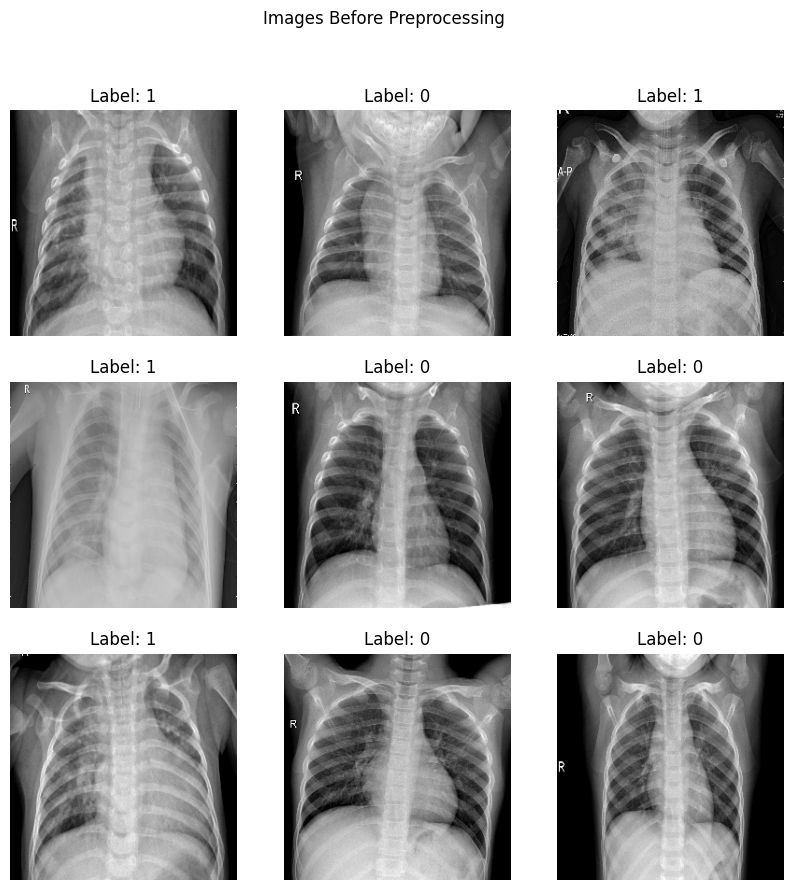

In [7]:
def show_images(images, labels, title):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].astype("uint8"))
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

show_images(val_images, val_labels, "Images Before Preprocessing")


In [8]:
from tensorflow.keras.applications.resnet import preprocess_input
# Apply ResNet50 preprocessing
train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y))
test_ds = val_ds.map(lambda x, y: (preprocess_input(x), y))

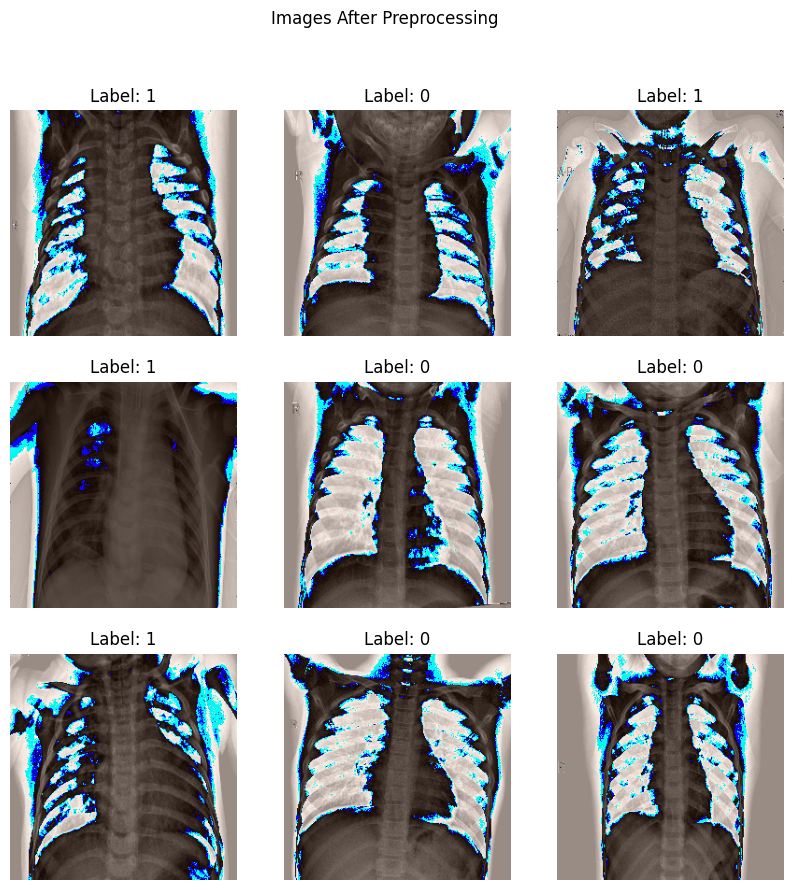

In [9]:
# Visualization of images after preprocessing
for images, labels in val_ds.take(1):  # Take one batch
    show_images(images.numpy(), labels.numpy(), "Images After Preprocessing")


In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping


In [11]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(243,243,3),
                   pooling='avg',
                   weights='imagenet')

for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(3, activation='softmax'))

In [12]:
resnet_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [13]:
resnet_model.compile(optimizer=Adam(learning_rate=0.001),
                     loss='sparse_categorical_crossentropy'
                     ,metrics=['accuracy'])

In [14]:
resnet_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [15]:
epochs=10
history = resnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 704s 3s/step - accuracy: 0.7251 - loss: 0.8693 - val_accuracy: 0.8329 - val_loss: 0.3949
Epoch 2/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 607s 3s/step - accuracy: 0.8243 - loss: 0.4163 - val_accuracy: 0.8443 - val_loss: 0.3736
Epoch 3/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 728s 4s/step - accuracy: 0.8377 - loss: 0.3846 - val_accuracy: 0.8519 - val_loss: 0.3667
Epoch 4/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 849s 4s/step - accuracy: 0.8399 - loss: 0.3657 - val_accuracy: 0.8608 - val_loss: 0.3418
Epoch 5/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 410s 2s/step - accuracy: 0.8530 - loss: 0.3342 - val_accuracy: 0.8684 - val_loss: 0.3383
Epoch 6/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 432s 2s/step - accuracy: 0.8636 - loss: 0.3104 - val_accuracy: 0.8354 - val_loss: 0.4168
Epoch 7/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 424s 2s/step - accuracy: 0.8630 - loss: 0.3289 - val_accuracy: 0.8608 - val_loss: 0.3729
Epoch 8/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 422s 2s/step - accuracy: 0.8803 - loss: 0.2970 - val_accu

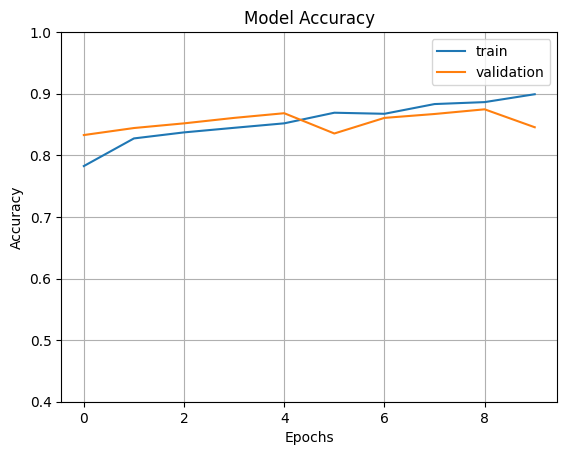

In [16]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

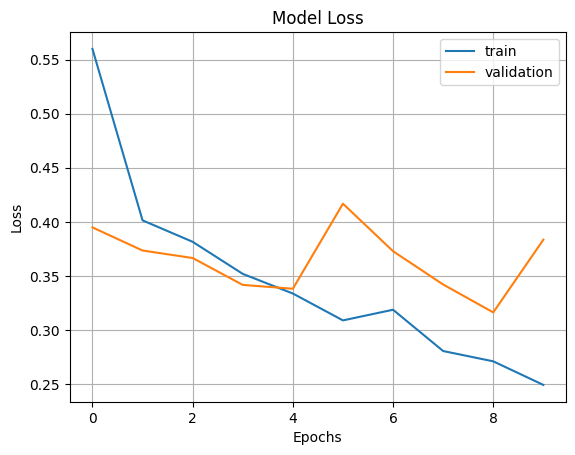

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [18]:
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np

#  Evaluate the model on the validation set
loss, accuracy = resnet_model.evaluate(test_ds)
print(f"Accuracy: {accuracy*100:.2f}%")
# Get predictions on test data
y_pred = resnet_model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert softmax output to class labels

# Get true labels
y_true = np.concatenate([y for x, y in val_ds], axis=0)

# Calculate precision
precision = precision_score(y_true, y_pred_classes, average='weighted')
print(f"Precision: {precision*100:.2f}%")

recall = recall_score(y_true, y_pred_classes, average='weighted')
print(f"Recall Score: {recall*100:.2f}%")

f1 = f1_score(y_true, y_pred_classes, average='weighted')
print(f"f1 score: {f1*100:.2f}%")



25/25 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.6982 - loss: 0.9297
Accuracy: 70.38%
25/25 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step
Precision: 75.83%
Recall Score: 70.38%
f1 score: 70.60%


In [19]:
# Visualization of predictions after training
def show_predictions(images, true_labels, pred_labels, title):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].astype("uint8"))
        plt.title(f'True: {true_labels[i]}\nPred: {pred_labels[i]}')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


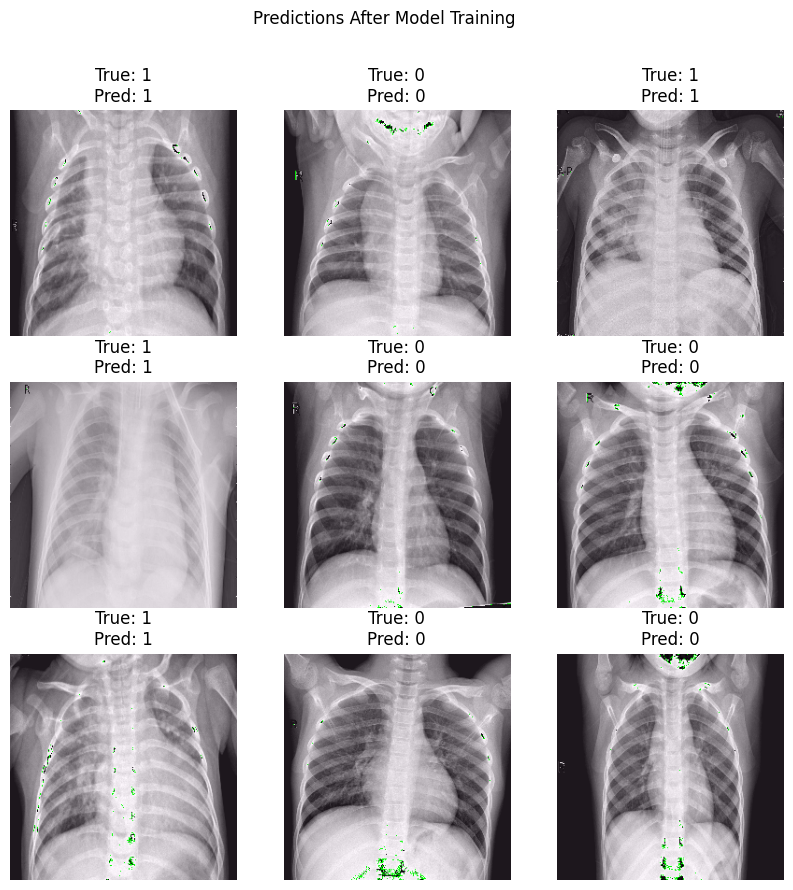

In [20]:
# Take a batch from test dataset for visualization
for images, true_labels in test_ds.take(1):  # Take one batch
    pred_labels = resnet_model.predict(images)
    pred_classes = np.argmax(pred_labels, axis=1)
    show_predictions(images.numpy(), true_labels.numpy(), pred_classes, "Predictions After Model Training")

In [21]:
# Print detailed classification report
from sklearn.metrics import classification_report


print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred_classes))


Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.63      0.77       333
           1       0.63      0.89      0.74       304
           2       0.50      0.50      0.50       153

    accuracy                           0.70       790
   macro avg       0.71      0.67      0.67       790
weighted avg       0.76      0.70      0.71       790



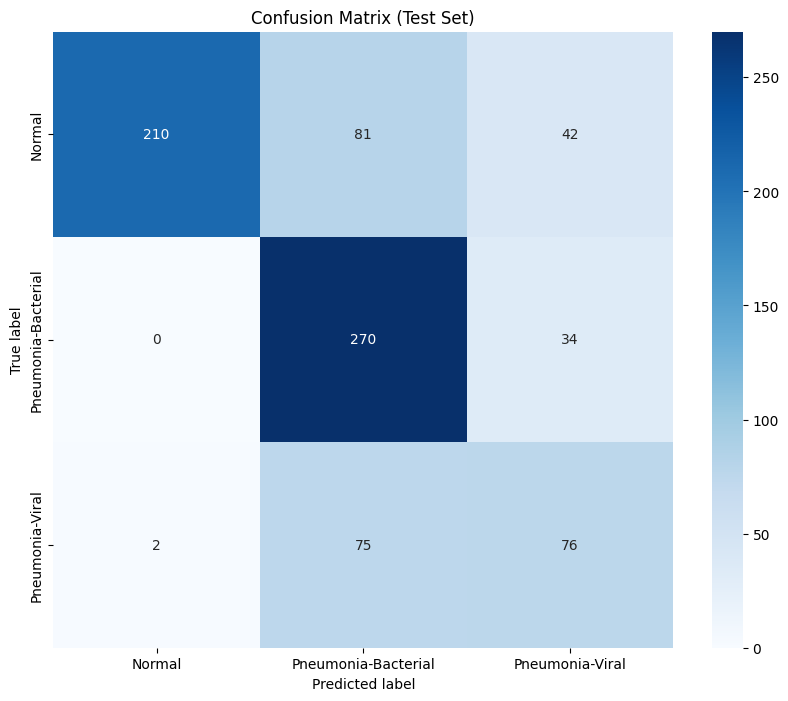

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, 
            xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix (Test Set)')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()